gender,Female,Gender diverse,Male,Unknown,total_gnrha,pop_f_0_17,pop_m_0_17,pop_0_17,m_rate_per_100k,f_rate_per_100k,...,3yr_duration_incidence,4yr_duration_incidence,5yr_duration_incidence,cumsum_3,cumsum_4,cumsum_5,pop_9_17,pop_period_start,cum_inc_per_9_17_100k,prev_per_9_17_100k
year,,,,,,,,,,,,,,,,,,,,,
2006-07-01,83.0,0.0,40.0,0.0,123,528260,552970,1081230,7.233665,15.711960,...,0,0,0,0,0,0,561950,NaN,NaN,0.000000
2007-07-01,86.0,0.0,25.0,0.0,111,530200,554610,1084770,4.507672,16.220294,...,0,0,0,0,0,0,559070,NaN,NaN,0.000000
2008-07-01,78.0,0.0,40.0,0.0,118,531060,556360,1087450,7.189589,14.687606,...,0,0,0,0,0,0,553930,NaN,NaN,0.000000
2009-07-01,81.0,0.0,45.0,0.0,126,531810,557800,1089620,8.067408,15.231004,...,0,0,0,0,0,0,550950,NaN,NaN,0.000000
2010-07-01,87.0,0.0,50.0,0.0,137,534760,561440,1096190,8.905671,16.268980,...,16,16,16,16,16,16,550830,550830.0,2.904707,2.904707
2011-07-01,98.0,0.0,45.0,0.0,143,535480,562460,1097940,8.000569,18.301337,...,6,6,6,22,22,22,547340,550830.0,3.993973,4.019439
2012-07-01,122.0,0.0,50.0,0.0,172,534380,562110,1096520,8.895056,22.830196,...,29,29,29,51,51,51,543880,550830.0,9.258755,9.377068
2013-07-01,149.0,0.0,69.0,0.0,218,533580,561630,1095200,12.285669,27.924585,...,62,46,46,113,97,97,541440,550830.0,20.514496,17.915189
2014-07-01,160.0,0.0,66.0,0.0,226,534430,562590,1097020,11.731456,29.938439,...,14,24,8,127,121,105,540000,550830.0,23.056115,19.444444


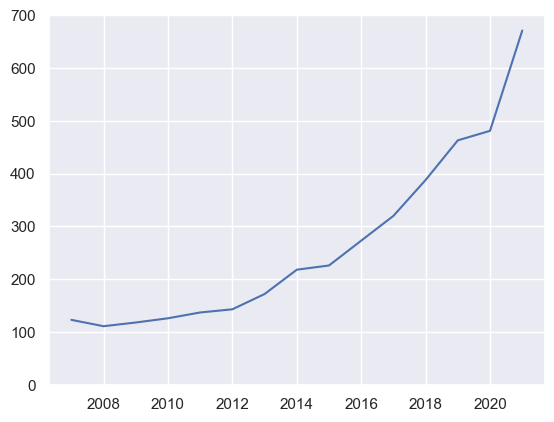

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import dataframe_image as dfi
import seaborn

import matplotlib.dates as mdates
from datetime import date
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

statistic = "gnrha_rate"
years = "2011_2020"
country = "nzl"
name = f"{country}_{statistic}_{years}"


gnrha_source = '2021_09_16_OIA_hormone_medicines_pharmac.xlsx'
pop_source = 'DPE403903_20220806_031634_89.csv'
drugs = pd.read_excel(
        f"../data/{gnrha_source}", 
        skiprows=8, 
        skipfooter=50,
        header=0,
        usecols=range(1, 22)
    ) 

drugs[['year', 'drug']] = drugs[['Financial_year', 'Chemical_group']].fillna(method="ffill")
drugs.set_index(['drug', 'year', 'gender'], inplace=True)
drugs.drop(labels=['Financial_year', 'Chemical_group'], axis=1, inplace=True)

mapper = { f"{y}/{y-1999:02}": f"{y}-07-01" for y in range(2006, 2021) }
drugs.rename(index=mapper, inplace=True)
gnrha = drugs.query("drug == 'GnRH_analogues'")
gnrha = gnrha.sort_index(ascending=True) 
gnrha = gnrha.sort_index(axis=1, ascending=True) 
gnrha = gnrha.fillna(0)

# Assume reported patients '< 10' with 'Unknown' sex was 1  
unknown = gnrha.query("gender == 'Unknown'")
unknown = unknown.replace("< 10", 1)
gnrha.update(unknown)

# Assume reported patients '< 10' with 'Gender diverse' sex was 1  
gd = gnrha.query("gender == 'Gender diverse'")
gd = gd.replace("< 10", 1)
gnrha.update(gd)

# Assume all other '< 10' are 1 
gnrha = gnrha.replace("< 10", 5)

pop = pd.read_csv(
        f"../data/{pop_source}",
        skiprows=2, 
        skipfooter=48,
        index_col=0,
        header=None,
        engine="python"
        )

def to_int(years):
    return int(years.replace(" Years", ""))

pop = pop.fillna(method="ffill", axis=1)
sex_age = [pop.iloc[0].tolist(), map(to_int, pop.iloc[1].tolist())]
cols = list(zip(*sex_age))
index_cols = pd.MultiIndex.from_tuples(cols, names=['sex', 'age'])

pop.index = pop.index.map(lambda x: f"{x}-07-01")
pop.columns = index_cols
pop = pop.iloc[2:]
pop.sort_index(axis=1, inplace=True, ascending=True) 
pop.sort_index(inplace=True, ascending=True) 
pop = pop.astype(int)

female_pop_0_17 = pop.loc[:, ("Female", slice(None))]
male_pop_0_17 = pop.loc[:, ("Male", slice(None))]
pop_0_17 = pop.loc[:, ("Total", slice(None))]

female_pop_0_17.columns = female_pop_0_17.columns.droplevel()
male_pop_0_17.columns = male_pop_0_17.columns.droplevel()
pop_0_17.columns = pop_0_17.columns.droplevel()

df = gnrha.sum(axis=1).to_frame().unstack().fillna(value=0).reset_index(level=0, drop=True)
df.columns = df.columns.droplevel()

df["total_gnrha"] = pd.to_numeric(df.sum(axis=1), downcast="integer")
df["pop_f_0_17"] = pd.to_numeric(female_pop_0_17.sum(axis=1), downcast="integer")
df["pop_m_0_17"] = pd.to_numeric(male_pop_0_17.sum(axis=1), downcast="integer")
df["pop_0_17"] = pop_0_17.sum(axis=1)
df["m_rate_per_100k"] = (df["Male"] / df["pop_m_0_17"]) * 100000
df["f_rate_per_100k"] = (df["Female"] / df["pop_f_0_17"]) * 100000
df["rate_per_100k"] = (df["total_gnrha"] / df["pop_0_17"]) * 100000
df["mean_rate_2006_2009"] = df.loc["2006-07-01":"2009-07-01", "rate_per_100k"].mean() 
df['cpp_other_n'] = pd.to_numeric(round((df['mean_rate_2006_2009'] / 100000) * df['pop_0_17']), downcast="integer")
df['total_excess'] = (df['total_gnrha'] - df['cpp_other_n'])
df['total_gnrha_gd'] = df["total_excess"]
df.loc["2006-07-01":"2009-07-01", "total_gnrha_gd"] = 0

def incidence_from_prevalence(series, window):
    incidences = []
    for i, prevalence in enumerate(series): 
        if i > (window - 2):
            incidence = prevalence - sum([incidences[i-j] for j in range(1, window)])
            incidences.append(incidence)
        else:
            incidences.append(prevalence)

    return incidences

df['3yr_duration_incidence'] = incidence_from_prevalence(df['total_gnrha_gd'], 3)
df['4yr_duration_incidence'] = incidence_from_prevalence(df['total_gnrha_gd'], 4)
df['5yr_duration_incidence'] = incidence_from_prevalence(df['total_gnrha_gd'], 5)
df['cumsum_3'] = df['3yr_duration_incidence'].cumsum()
df['cumsum_4'] = df['4yr_duration_incidence'].cumsum()
df['cumsum_5'] = df['5yr_duration_incidence'].cumsum()
df['pop_9_17'] = pop_0_17.loc[:, 9:17].sum(axis=1)
df['pop_period_start'] = df.loc["2010-07-01", "pop_9_17"]
df.loc["2006-07-01":"2009-7-01", 'pop_period_start'] = None

df['cum_inc_per_9_17_100k'] = (df['cumsum_3'] / df['pop_period_start']) * 100000
df['prev_per_9_17_100k'] = (df['total_gnrha_gd'] / df['pop_9_17']) * 100000


df.to_csv(f"../results/{name}.csv", float_format="%.2f")


## Figures and Tables

seaborn.set_theme()

df1 = pd.DataFrame({
                        'total_gnrha': df['total_gnrha'].tolist()
                    },
                    index=pd.to_datetime([f"{y}-01-01" for y in range(2007, 2022)]))
df1.index.name = 'year'



seaborn.lineplot(x='year', y='total_gnrha', data=df1)
plt.xlabel(None)
plt.ylabel(None)
plt.ylim([0, 700])

df

